In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from shapely.geometry import box


import warnings
warnings.filterwarnings("ignore")

def save(title):
    ts = int(datetime.now().timestamp())
    
    plt.savefig(f'{title}_{ts}.png')

In [2]:
# Quickly draw basemap
# A value of true will generate map backrounds with simple lines to represent borders
# A value of False will use satellite imagery 
quick_bm = True

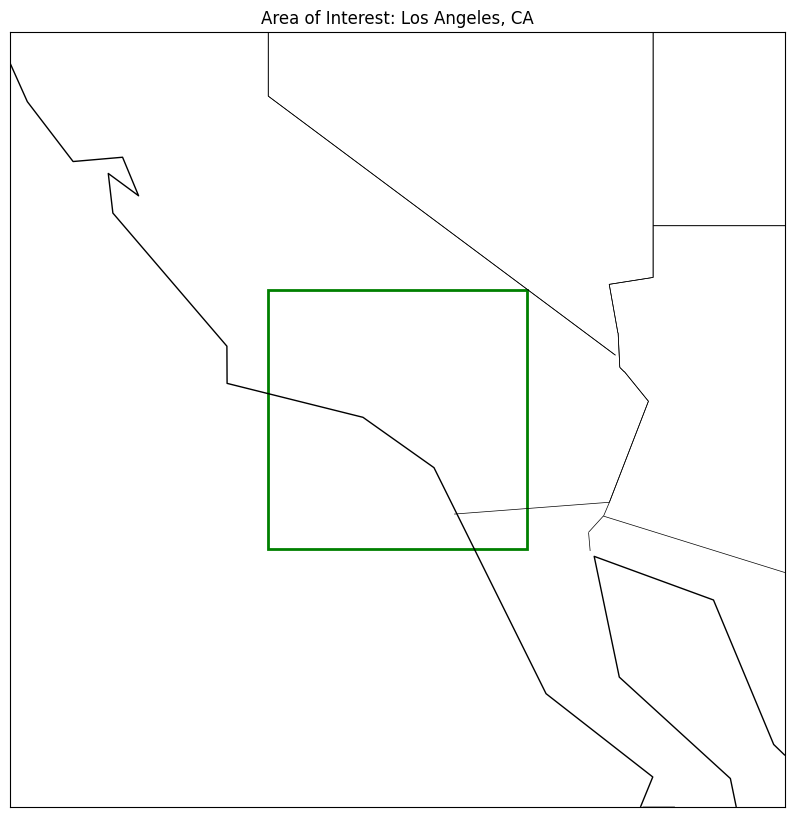

In [3]:
bounds_min_lat = 32.0
bounds_max_lat = 36.0
bounds_min_lon = -120.0
bounds_max_lon = -116.0

bounds_lat = slice(bounds_min_lat, bounds_max_lat)
bounds_lon = slice(bounds_min_lon, bounds_max_lon)

bounding_poly = box(bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat)

margin = 4

map = Basemap(
    projection='cyl',
    llcrnrlat=bounds_min_lat - margin,
    urcrnrlat=bounds_max_lat + margin,
    llcrnrlon=bounds_min_lon - margin,
    urcrnrlon=bounds_max_lon + margin,
)

if quick_bm:
    map.drawcoastlines()
    map.drawcountries()
    map.drawstates()
else:
    map.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', 
                    service='World_Imagery',
                    xpixels=2000, ypixels=None, dpi= 2000, verbose=False)

poly = Polygon([(bounds_min_lon,bounds_min_lat),(bounds_min_lon,bounds_max_lat),(bounds_max_lon,bounds_max_lat),(bounds_max_lon,bounds_min_lat)],
                facecolor=(0,0,0,0.0),edgecolor='green',linewidth=2)
plt.gca().add_patch(poly)
plt.gcf().set_size_inches(10,15)

plt.title('Area of Interest: Los Angeles, CA')
    
plt.show()

In [19]:
# Open zarr datasets - LOCAL

method = 'linear'

l3_pre_qf = xr.open_zarr(f'data/zarr/la_sams_sample_pre_qf_1km_{method}_scaled.zarr', consolidated=True).sel(latitude=bounds_lat, longitude=bounds_lon)
l3_post_qf = xr.open_zarr(f'data/zarr/la_sams_sample_post_qf_1km_{method}_scaled.zarr', consolidated=True).sel(latitude=bounds_lat, longitude=bounds_lon)

pre_interp_m = l3_pre_qf.attrs.get('interpolation_method', None)
post_interp_m = l3_post_qf.attrs.get('interpolation_method', None)

pre_res = l3_pre_qf.attrs.get('resolution', None)
post_res = l3_post_qf.attrs.get('resolution', None)

pre_res_s = f' [{pre_res}]' if pre_res is not None else ''
post_res_s = f' [{post_res}]' if post_res is not None else ''

# Clear the plot dict so if we switch L3 ds's it doesn't point to the old ones
plot_dict = {}

l3_post_qf

<xarray.Dataset>
Dimensions:           (latitude: 400, longitude: 400, time: 1)
Coordinates:
  * latitude          (latitude) float32 32.01 32.02 32.03 ... 35.98 35.99 36.0
  * longitude         (longitude) float32 -120.0 -120.0 -120.0 ... -116.0 -116.0
  * time              (time) datetime64[ns] 2020-05-05T07:00:00
Data variables:
    xco2              (time, longitude, latitude) float64 dask.array<chunksize=(1, 250, 50), meta=np.ndarray>
    xco2_uncertainty  (time, longitude, latitude) float64 dask.array<chunksize=(1, 250, 50), meta=np.ndarray>
Attributes:
    interpolation_method:  linear
    resolution:            1km

In [4]:
# Open Zarr datasets - AWS S3

import s3fs
import json

method = 'linear'

pre_qf_path = 's3://sdap-dev-zarr/OCO3/outputs/la_sams_sample_pre_qf_1km_linear.zarr'
post_qf_path = 's3://sdap-dev-zarr/OCO3/outputs/la_sams_sample_post_qf_1km_linear.zarr'

with open('SRV-sdap-dev.json', 'r') as f:
    creds = json.load(f)
    
s3 = s3fs.S3FileSystem(
    False,
    key=creds['accessKeyID'],
    secret=creds['secretAccessKey']
)

store_pre_qf = s3fs.S3Map(root=pre_qf_path, s3=s3, check=False)
store_post_qf = s3fs.S3Map(root=post_qf_path, s3=s3, check=False)

l3_pre_qf = xr.open_zarr(store_pre_qf, consolidated=True).sel(latitude=bounds_lat, longitude=bounds_lon)
l3_post_qf = xr.open_zarr(store_post_qf, consolidated=True).sel(latitude=bounds_lat, longitude=bounds_lon)

pre_interp_m = l3_pre_qf.attrs.get('interpolation_method', None)
post_interp_m = l3_post_qf.attrs.get('interpolation_method', None)

pre_res = l3_pre_qf.attrs.get('resolution', None)
post_res = l3_post_qf.attrs.get('resolution', None)

pre_res_s = f' [{pre_res}]' if pre_res is not None else ''
post_res_s = f' [{post_res}]' if post_res is not None else ''

# Clear the plot dict so if we switch L3 ds's it doesn't point to the old ones
plot_dict = {}
del creds

l3_post_qf

<xarray.Dataset>
Dimensions:           (latitude: 400, longitude: 400, time: 8)
Coordinates:
  * latitude          (latitude) float32 32.01 32.02 32.03 ... 35.98 35.99 36.0
  * longitude         (longitude) float32 -120.0 -120.0 -120.0 ... -116.0 -116.0
  * time              (time) datetime64[ns] 2020-03-03 2020-05-05 ... 2022-10-28
Data variables:
    xco2              (time, longitude, latitude) float64 dask.array<chunksize=(5, 250, 50), meta=np.ndarray>
    xco2_uncertainty  (time, longitude, latitude) float64 dask.array<chunksize=(5, 250, 50), meta=np.ndarray>
Attributes:
    interpolation_method:  linear
    resolution:            1km

In [5]:
granules = [
    "data/netcdf/oco3_LtCO2_200303_B10400Br_220318000013s.nc4",
    "data/netcdf/oco3_LtCO2_200505_B10400Br_220318001036s.nc4",
    "data/netcdf/oco3_LtCO2_200527_B10400Br_220318001255s.nc4",
    "data/netcdf/oco3_LtCO2_200814_B10400Br_220318002549s.nc4",
    "data/netcdf/oco3_LtCO2_210325_B10400Br_220318010127s.nc4",
    "data/netcdf/oco3_LtCO2_220218_B10400Br_220505141844s.nc4",
    "data/netcdf/oco3_LtCO2_220813_B10400Br_221010202453s.nc4",
    "data/netcdf/oco3_LtCO2_221028_B10400Br_221205203441s.nc4",
]

sams_pre_qf = []
sams_post_qf = []

for granule in granules:
    print(f'Processing granule {granule}')
    ds = xr.open_dataset(granule)
    ds_s = xr.open_dataset(granule, group='Sounding')
    
    latitudes = ds.latitude.to_numpy()
    longitudes = ds.longitude.to_numpy()
    
    lats_in_bounds = np.logical_and(bounds_min_lat <= latitudes, latitudes <= bounds_max_lat)
    lons_in_bounds = np.logical_and(bounds_min_lon <= longitudes, longitudes <= bounds_max_lon)
    
    in_bounds = np.logical_and(lats_in_bounds, lons_in_bounds)
    
    ds = ds.isel(sounding_id=in_bounds)
    ds_s = ds_s.isel(sounding_id=in_bounds)
    
    mode_array = ds_s['operation_mode']

    sam_slices = []
    sam = False

    start = None
    for i, v in enumerate(mode_array.to_numpy()):
        if v.item() == 4:
            if not sam:
                sam = True
                start = i
        else:
            if sam:
                sam = False
                sam_slices.append(slice(start, i))

    if sam:
        sam_slices.append(slice(start, i))
        
    extracted_sams_pre_qf = []
    extracted_sams_post_qf = []
    
    for s in sam_slices:
        sam = ds.isel(sounding_id=s)
        
        extracted_sams_pre_qf.append(sam)
        
        quality = sam.xco2_quality_flag == 0
        
        if not any(quality):
            continue
            
        extracted_sams_post_qf.append(sam.where(quality, drop=True))
        
    if extracted_sams_pre_qf:
        sams_pre_qf.append(xr.concat(extracted_sams_pre_qf, 'sounding_id'))
    
    if extracted_sams_post_qf:
        sams_post_qf.append(xr.concat(extracted_sams_post_qf, 'sounding_id'))
        
print('Done')

Processing granule data/netcdf/oco3_LtCO2_200303_B10400Br_220318000013s.nc4
Processing granule data/netcdf/oco3_LtCO2_200505_B10400Br_220318001036s.nc4
Processing granule data/netcdf/oco3_LtCO2_200527_B10400Br_220318001255s.nc4
Processing granule data/netcdf/oco3_LtCO2_200814_B10400Br_220318002549s.nc4
Processing granule data/netcdf/oco3_LtCO2_210325_B10400Br_220318010127s.nc4
Processing granule data/netcdf/oco3_LtCO2_220218_B10400Br_220505141844s.nc4
Processing granule data/netcdf/oco3_LtCO2_220813_B10400Br_221010202453s.nc4
Processing granule data/netcdf/oco3_LtCO2_221028_B10400Br_221205203441s.nc4
Done


In [6]:
plot_dict = {}

EPOCH = datetime(1970, 1, 1, 0, 0, 0)

for i in range(len(l3_post_qf.time)):
    ds_slice = l3_post_qf.isel(time=i)
    
    ts = ((ds_slice.time.to_numpy() - np.datetime64(EPOCH)) / 1e9).astype(int).item()
    t = np.datetime_as_string(ds_slice.time.to_numpy()).item().split('T')[0]
    
    plot_dict[t] = {'l3_post': ds_slice}
    
for i in range(len(l3_pre_qf.time)):
    ds_slice = l3_pre_qf.isel(time=i)
    
    ts = ((ds_slice.time.to_numpy() - np.datetime64(EPOCH)) / 1e9).astype(int).item()
    t = np.datetime_as_string(ds_slice.time.to_numpy()).item().split('T')[0]
    
    plot_dict[t]['l3_pre'] = ds_slice
    
for sam in sams_pre_qf:
    date = tuple(sam.date[0][:3].to_numpy().astype(int))
    
    t = datetime(*date).strftime('%Y-%m-%d')
    if t in plot_dict:
        plot_dict[t]['l2_pre'] = sam
    else:
        print(f'{t} not in plot dict {plot_dict.keys()}')
    
for sam in sams_post_qf:
    date = tuple(sam.date[0][:3].to_numpy().astype(int))
    
    t = datetime(*date).strftime('%Y-%m-%d')
    if t in plot_dict:
        plot_dict[t]['l2_post'] = sam
    else:
        print(f'{t} not in plot dict {plot_dict.keys()}')
        
print(f'Built plot dict for {len(plot_dict)} day(s)')

Built plot dict for 8 day(s)


In [7]:
def basemap(ax, bounds, margin):
    m=Basemap(
        projection='cyl',
        lon_0=180,
        llcrnrlat=bounds[0] - margin,
        urcrnrlat=bounds[1] + margin,
        llcrnrlon=bounds[2] - margin,
        urcrnrlon=bounds[3] + margin,
        ax=ax,
    )

    if quick_bm: 
        m.drawcoastlines()
    else:
        m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', 
                      service='World_Imagery',
                      xpixels=2000, ypixels=None, dpi= 2000, verbose=False)
    
    return m

def plot_l2(ds, axis, title, vmin=None, vmax=None):
    min_lat = ds.latitude.min().item()
    min_lon = ds.longitude.min().item()
    max_lat = ds.latitude.max().item()
    max_lon = ds.longitude.max().item()
    
    m = basemap(axis, (min_lat,max_lat,min_lon,max_lon), 0.5)
    
    m.drawparallels(np.arange(-90.,91.,1), labels=[True, False, False, True])
    m.drawmeridians(np.arange(-180.,181.,1), labels=[True, False, False, True])
    
    patches = []
    
    cmap = plt.get_cmap('viridis')
    
    for i in range(len(ds.xco2)):
        value = ds.xco2[i].item()
        
        v_lat = ds.vertex_latitude[i].to_numpy()
        v_lon = ds.vertex_longitude[i].to_numpy()
        
        patches.append(
            Polygon(
                np.column_stack((v_lon, v_lat)), 
                closed=True, 
                # facecolor=cmap(value)
            )
        )
        
    collection = PatchCollection(patches, cmap=cmap)
    collection.set_array(ds.xco2.to_numpy())
    collection.set_clim(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(collection, ax=axis, label='$X_{CO_2}$ [ppm]')
    axis.add_collection(collection)
    
    axis.set_title(f'{title} ({len(patches):,} soundings)')
    
    return min_lat,max_lat,min_lon,max_lon
    
def plot_l2_center(ds, axis, title, vmin=None, vmax=None):
    min_lat = ds.latitude.min().item()
    min_lon = ds.longitude.min().item()
    max_lat = ds.latitude.max().item()
    max_lon = ds.longitude.max().item()
        
    m = basemap(axis, (min_lat,max_lat,min_lon,max_lon), 0.5)
    
    m.drawparallels(np.arange(-90.,91.,0.5), labels=[True, False, False, True])
    m.drawmeridians(np.arange(-180.,181.,0.5), labels=[True, False, False, True])
    
    cmap = plt.get_cmap('viridis')
    
    x, y = m(ds.longitude.to_numpy(), ds.latitude.to_numpy())
    
    sc = axis.scatter(x,y,1,marker=',',c=ds.xco2.to_numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(sc, ax=axis, label='$X_{CO_2}$ [ppm]')
    
    axis.set_title(title)

def plot_l3(ds, axis, title, bounds, vmin, vmax):
    m = basemap(axis, bounds, 0.5)
    
    m.drawparallels(np.arange(-90.,91.,1), labels=[True, False, False, True])
    m.drawmeridians(np.arange(-180.,181.,1), labels=[True, False, False, True])
    
    cmap = plt.get_cmap('viridis')
    
    x, y = m(ds.longitude.to_numpy(), ds.latitude.to_numpy())
    cs=m.pcolormesh(x,y,ds.xco2.transpose().to_numpy(), vmin=vmin, vmax=vmax)
    cb = plt.colorbar(cs, ax=axis, label='$X_{CO_2}$ [ppm]')
    
    axis.set_title(title)
    
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))
    
# plot_l2(plot_dict['2022-10-28']['l2_pre'], ax1, 'l2_pre')
# plot_l2(plot_dict['2022-10-28']['l2_post'], ax2, 'l2_post')

# plot_l3(plot_dict['2022-10-28']['l3_pre'], ax3, 'l3_pre')
# plot_l3(plot_dict['2022-10-28']['l3_post'], ax4, 'l3_post')

# fig.suptitle('test')

# fig.tight_layout()

# save('plots/demo')
# plt.show()

In [8]:
def plot_day(day):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))
    
    ds = plot_dict[day]
    
    vmin = min([np.nanmin(ds[p].xco2.to_numpy()).item() for p in ds])
    vmax = max([np.nanmax(ds[p].xco2.to_numpy()).item() for p in ds])
    
    b_pre = plot_l2(ds['l2_pre'], ax1, 'L2_traj_pre_qf_filter', vmin, vmax)
    b_post = plot_l2(ds['l2_post'], ax2, 'L2_traj_post_qf_filter', vmin, vmax)
    
    method_string_pre = f' ({pre_interp_m})' if pre_interp_m is not None else ''
    method_string_post = f' ({post_interp_m})' if post_interp_m is not None else ''

    plot_l3(ds['l3_pre'], ax3, f'L3_glob_pre_qf_filter{method_string_pre}{pre_res_s}', b_pre, vmin, vmax)
    plot_l3(ds['l3_post'], ax4, f'L3_glob_post_qf_filter{method_string_post}{post_res_s}', b_post, vmin, vmax)
    
    fig.suptitle(f'Plots for {day}')

    fig.tight_layout()

    save(f'plots/plots_{day}')
    plt.show()
    
# plot_day('2022-10-28')

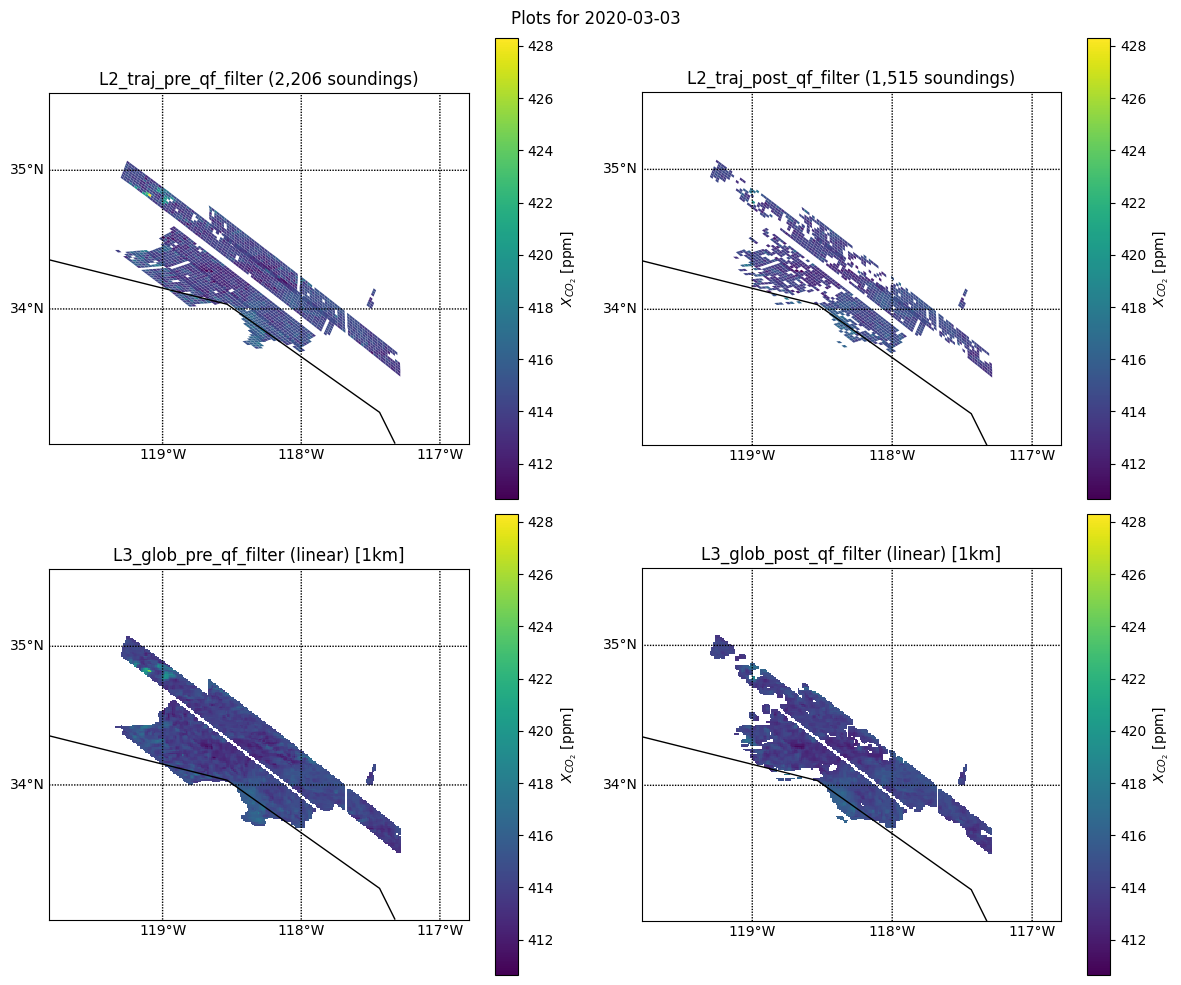

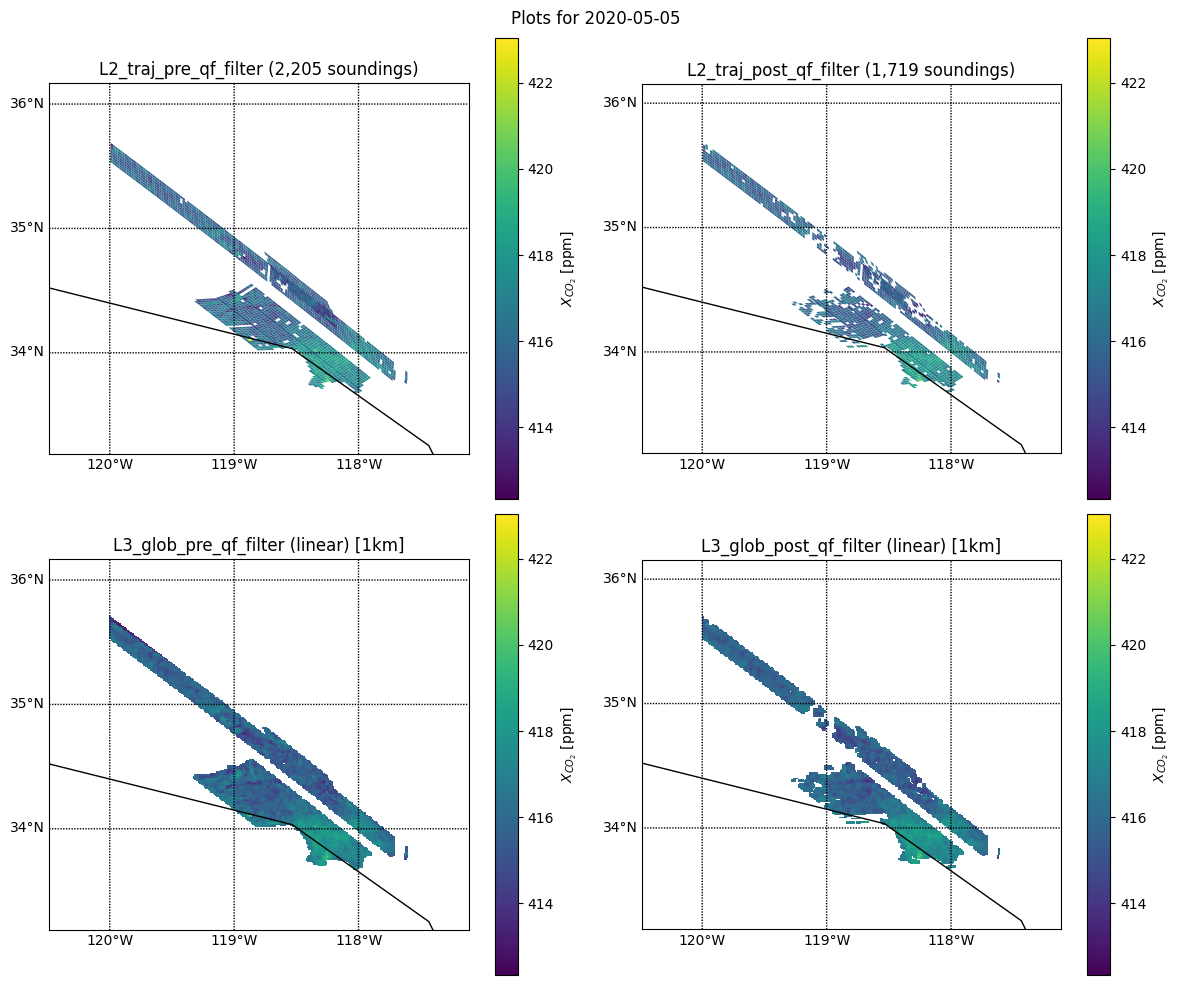

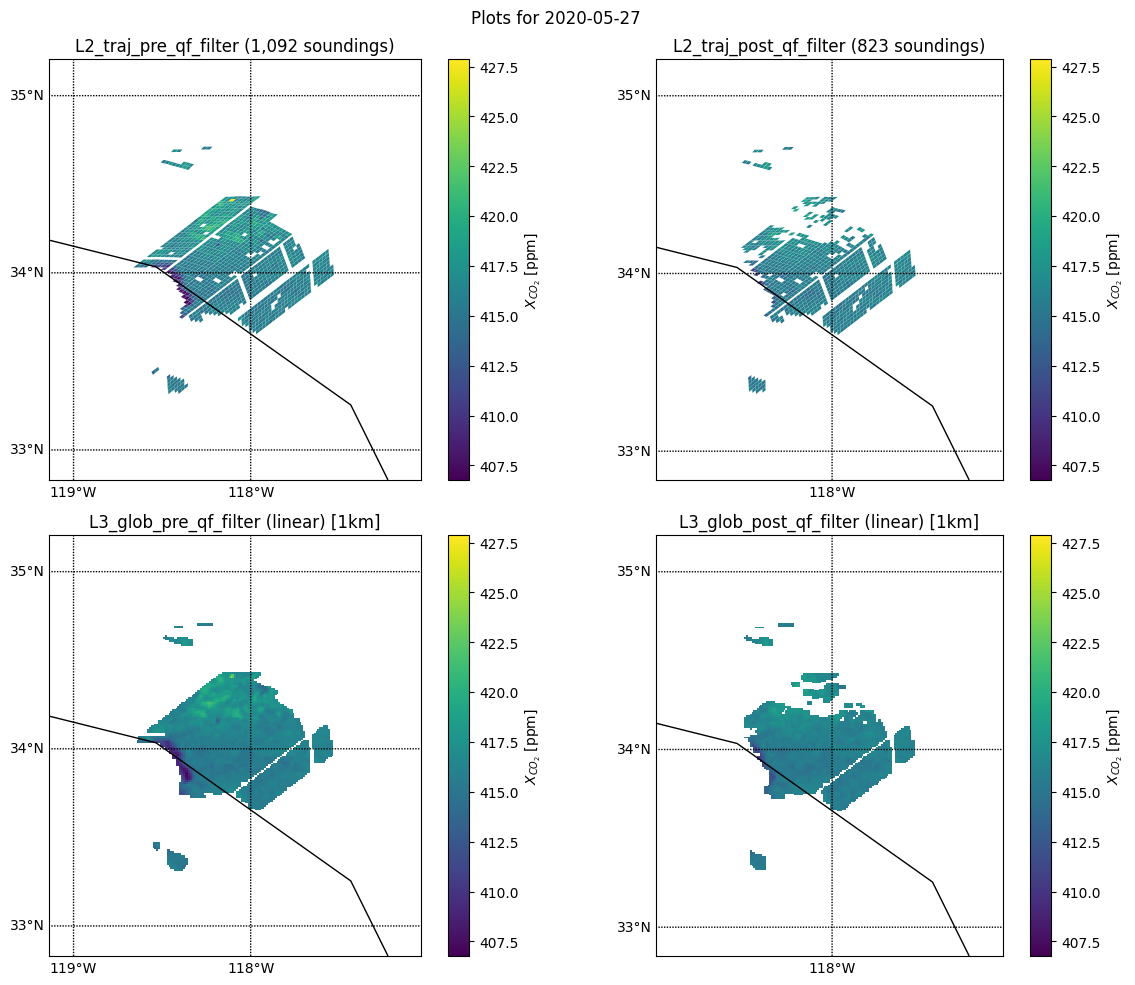

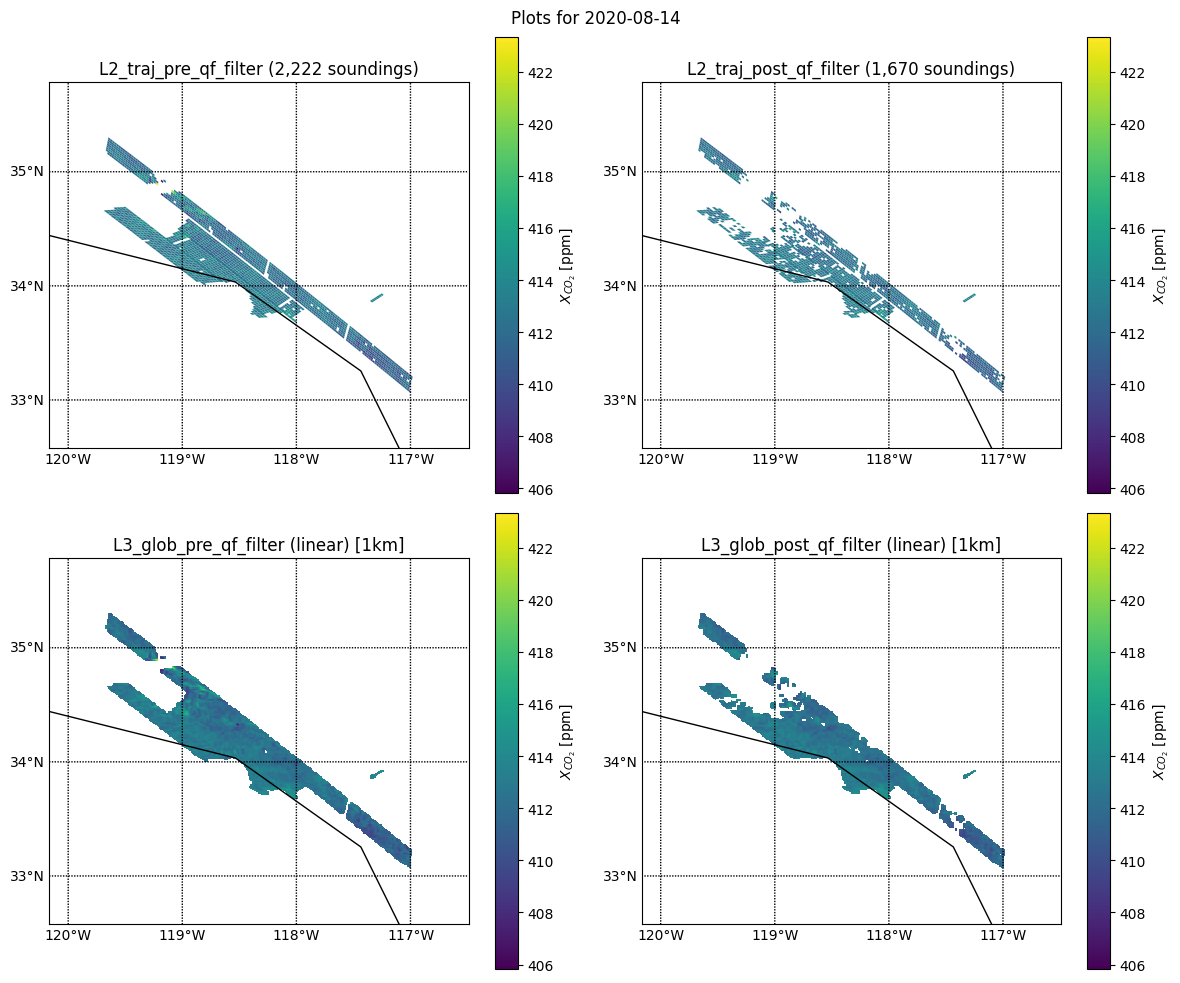

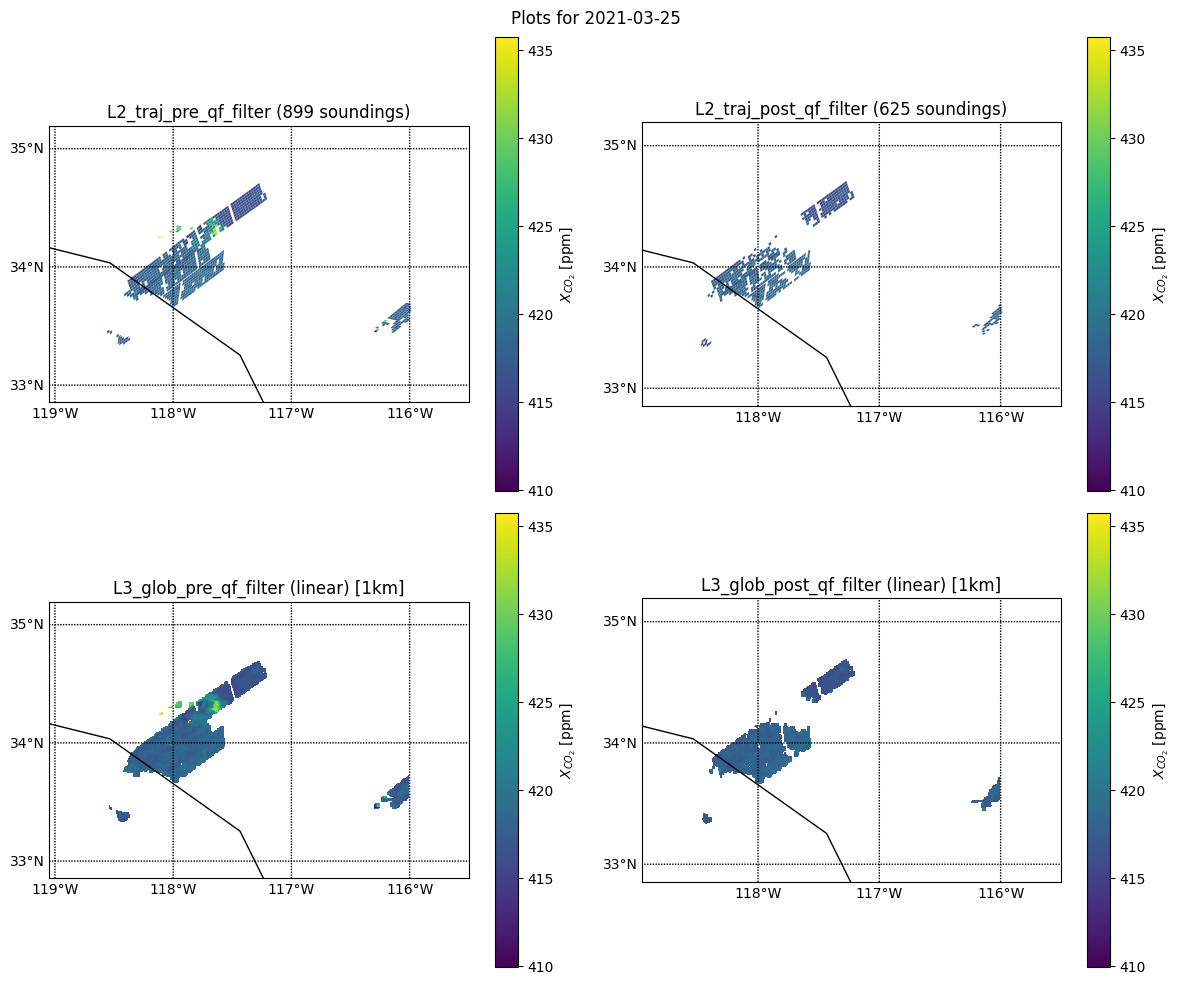

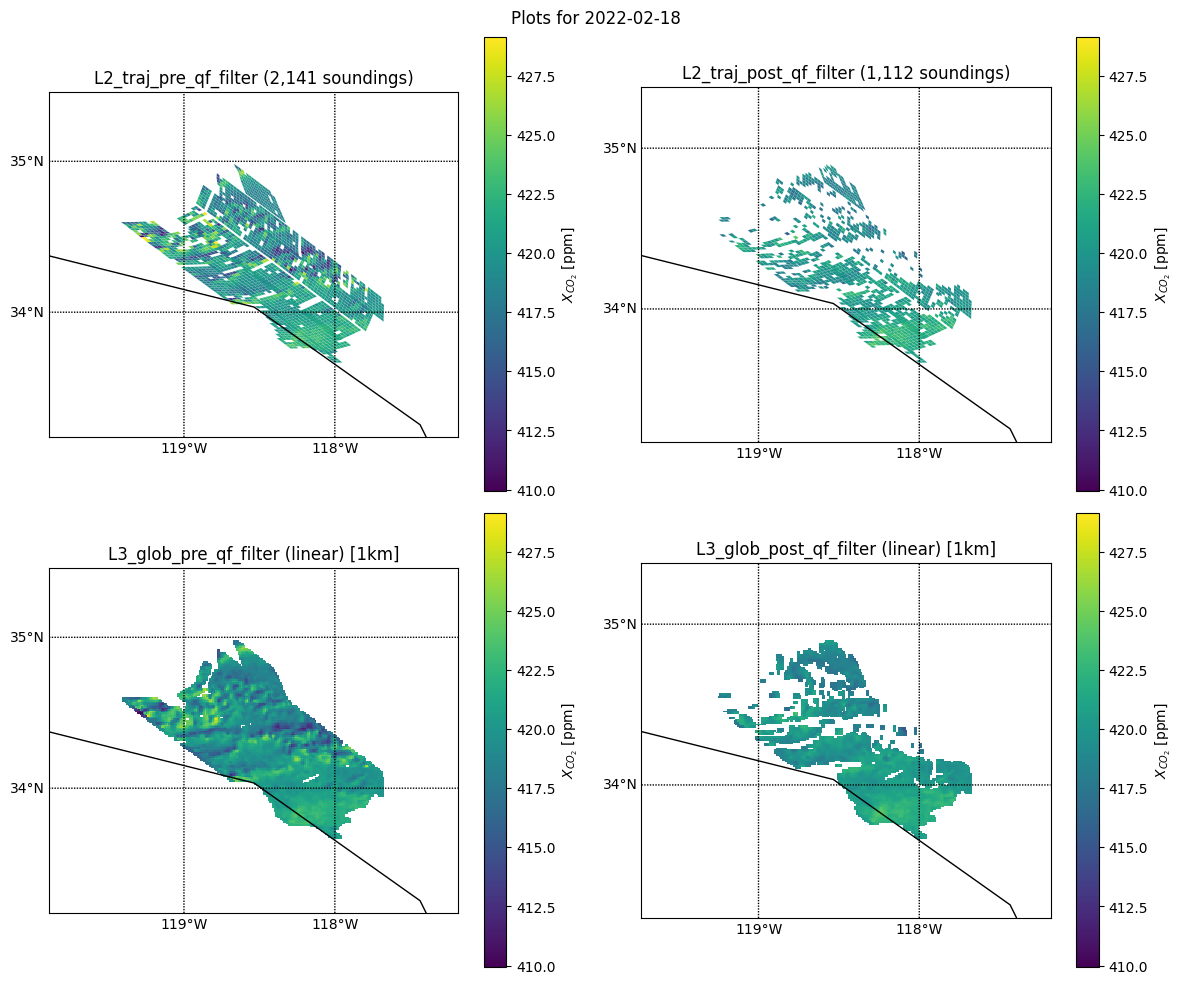

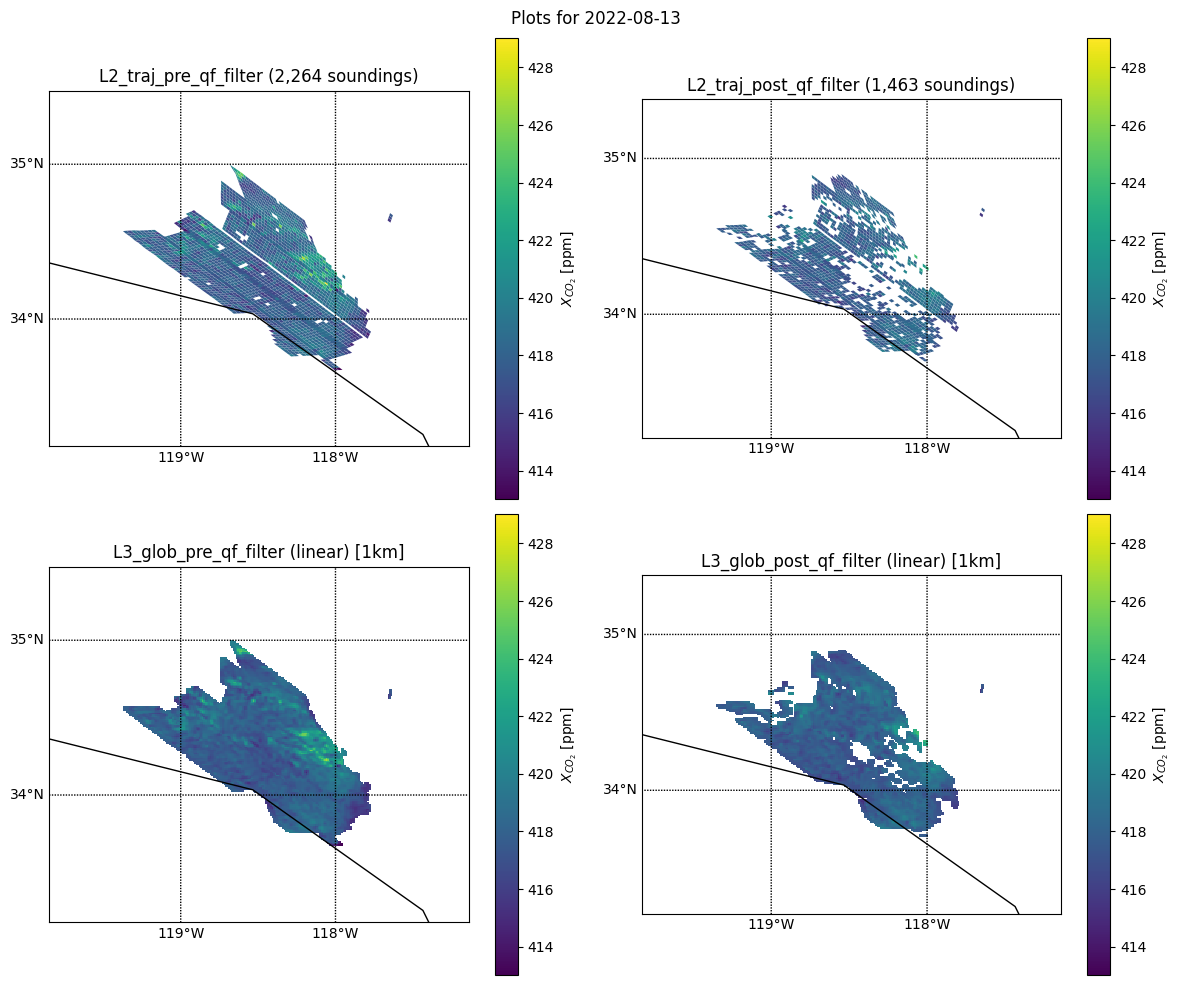

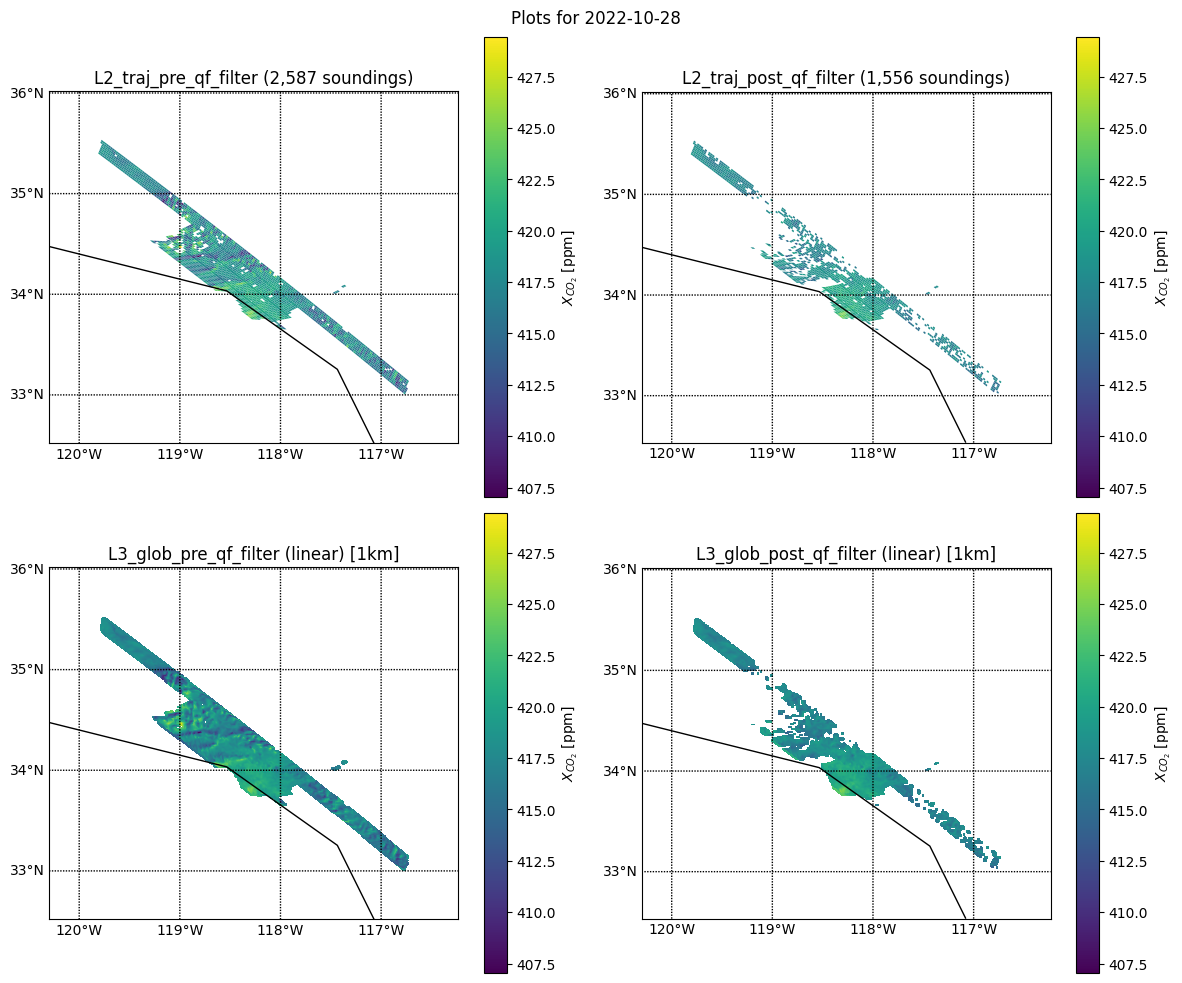

In [9]:
# NOTE: These may take a VERY long time to generate!!!

for day in plot_dict:
    plot_day(day)

In [6]:
# Now try running a timeseries in SDAP

import requests
import json

sdap_url = 'http://localhost:8083/timeSeriesSpark'

params = {
    "ds": "oco3_sams_l3_pre_qf",
    "b": "-120,32,-116,36",
    "startTime": "2020-03-03T00:00:00Z",
    "endTime": "2022-11-04T00:00:00Z"
}

response = requests.get(sdap_url, params=params)
response.raise_for_status()
pre_qf_timeseries = response.json()['data']

params['ds'] = "oco3_sams_l3_post_qf"

response = requests.get(sdap_url, params=params)
response.raise_for_status()
post_qf_timeseries = response.json()['data']

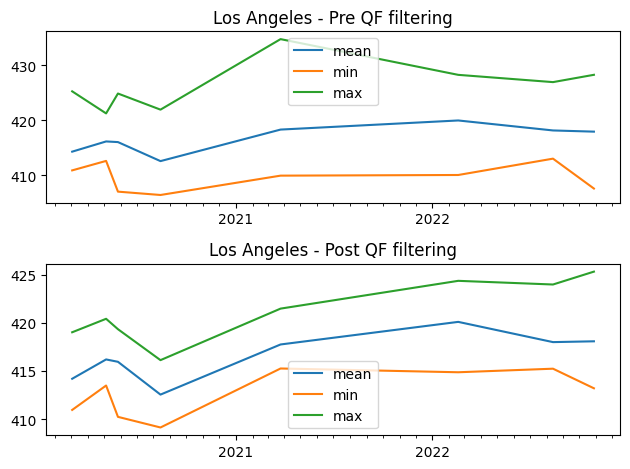

In [30]:
def convert_time_array(t):
    return np.array(t, dtype='datetime64[s]')

fig, (ax1, ax2) = plt.subplots(2)

pre_qf_times = convert_time_array([d[0]['time'] for d in pre_qf_timeseries])
ax1.plot(
    pre_qf_times, [d[0]['mean'] for d in pre_qf_timeseries],
    pre_qf_times, [d[0]['min'] for d in pre_qf_timeseries], 
    pre_qf_times, [d[0]['max'] for d in pre_qf_timeseries], 
)

ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

ax1.legend(['mean', 'min', 'max'])
ax1.set_title('Los Angeles - Pre QF filtering')

post_qf_times = convert_time_array([d[0]['time'] for d in post_qf_timeseries])
ax2.plot(
    post_qf_times, [d[0]['mean'] for d in post_qf_timeseries], 
    post_qf_times, [d[0]['min'] for d in post_qf_timeseries], 
    post_qf_times, [d[0]['max'] for d in post_qf_timeseries], 
)

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_minor_locator(mdates.MonthLocator())

ax2.legend(['mean', 'min', 'max'])
ax2.set_title('Los Angeles - Post QF filtering')

fig.tight_layout()

plt.show()